In [77]:
# Plot 3C waveforms of the whole array in a time window

In [78]:
## Import modules
from obspy import read, UTCDateTime, Stream
from matplotlib.pyplot import figure, subplots
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from numpy import abs, mean, amin, amax
from pandas import read_csv, Timestamp, Timedelta
from os.path import join

from utils_basic import ROOTDIR, INNER_STATIONS_A, INNER_STATIONS_B, days_to_timestamps
from utils_preproc import preprocess_stream
from utils_sta_lta import read_associated_events


In [79]:
## Inputs

starttime = Timestamp("2020-01-11T19:40:20")
dur = 2.5 # Duration in seconds
subarray = "B" # Subarray to plot
plot_detect = False # Plot STA/LTA detections or not
plot_assoc = False # Plot associated detections or not
sta_lta_dir = "detections_sta0.01s_lta0.20s_on5_off2"
assoc_dir = "associated_events_num8_delta0.200s"

freqmin = 10.0
freqmax = 450

scale = 3.75e-5 # Scale factor for plotting
scalebar = 8000 # Scale bar length in nm/s
size = 30 # Size of the dots for detections

In [80]:
## Read the station list
if subarray == "A":
    stations_to_plot = INNER_STATIONS_A
elif subarray == "B":
    stations_to_plot = INNER_STATIONS_B
else:
    raise ValueError("Invalid subarray")

inpath = join(ROOTDIR, "stations.csv")
stadf = read_csv(inpath, index_col=0)
stadf = stadf.loc[stadf["name"].isin(stations_to_plot)]
numst = len(stadf)

In [81]:
## Read the raw detections
stalta_dict = {}    
if plot_detect:
    for station in stadf["name"]:
        inpath = join(ROOTDIR, sta_lta_dir, f"{station}.csv")
        detdf = read_csv(inpath, index_col=0, parse_dates=["trigger_time", "detrigger_time"])
        stalta_dict[station] = detdf

In [82]:
## Read the associated detections
if plot_assoc:
    inpath = join(ROOTDIR, sta_lta_dir, assoc_dir, "events_a.dat")
    events = read_associated_events(inpath)

    ## Get the events in the time window
    events = events.get_events_in_interval(starttime, starttime+Timedelta(seconds=dur))

In [83]:
## Read and preprocess the data
starttime = UTCDateTime(starttime)
timewin = starttime.strftime("%Y-%m-%d-%H-00-00")
stream = Stream()
for station in stadf["name"]:
    try:
        pattern = join(ROOTDIR, timewin, f"*{station}*.SAC")
        stream += read(pattern)
    except:
        print(f"Could not read Station {station}")
        continue

stream = preprocess_stream(stream, freqmin, freqmax)
stream.trim(starttime, starttime + dur)

15 Trace(s) in Stream:
7F.B01..GH1 | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B01..GH2 | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B01..GHZ | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B02..GH1 | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B02..GH2 | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B02..GHZ | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B03..GH1 | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B03..GH2 | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B03..GHZ | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 samples
7F.B04..GH1 | 2020-01-11T19:40:20.000148Z - 2020-01-11T19:40:22.500148Z | 1000.0 Hz, 2501 sampl

Saved to /Volumes/OmanData/geophones_no_prefilt/data/2020-01-11-19-00-00/inner_station_sample_waveforms_b.png


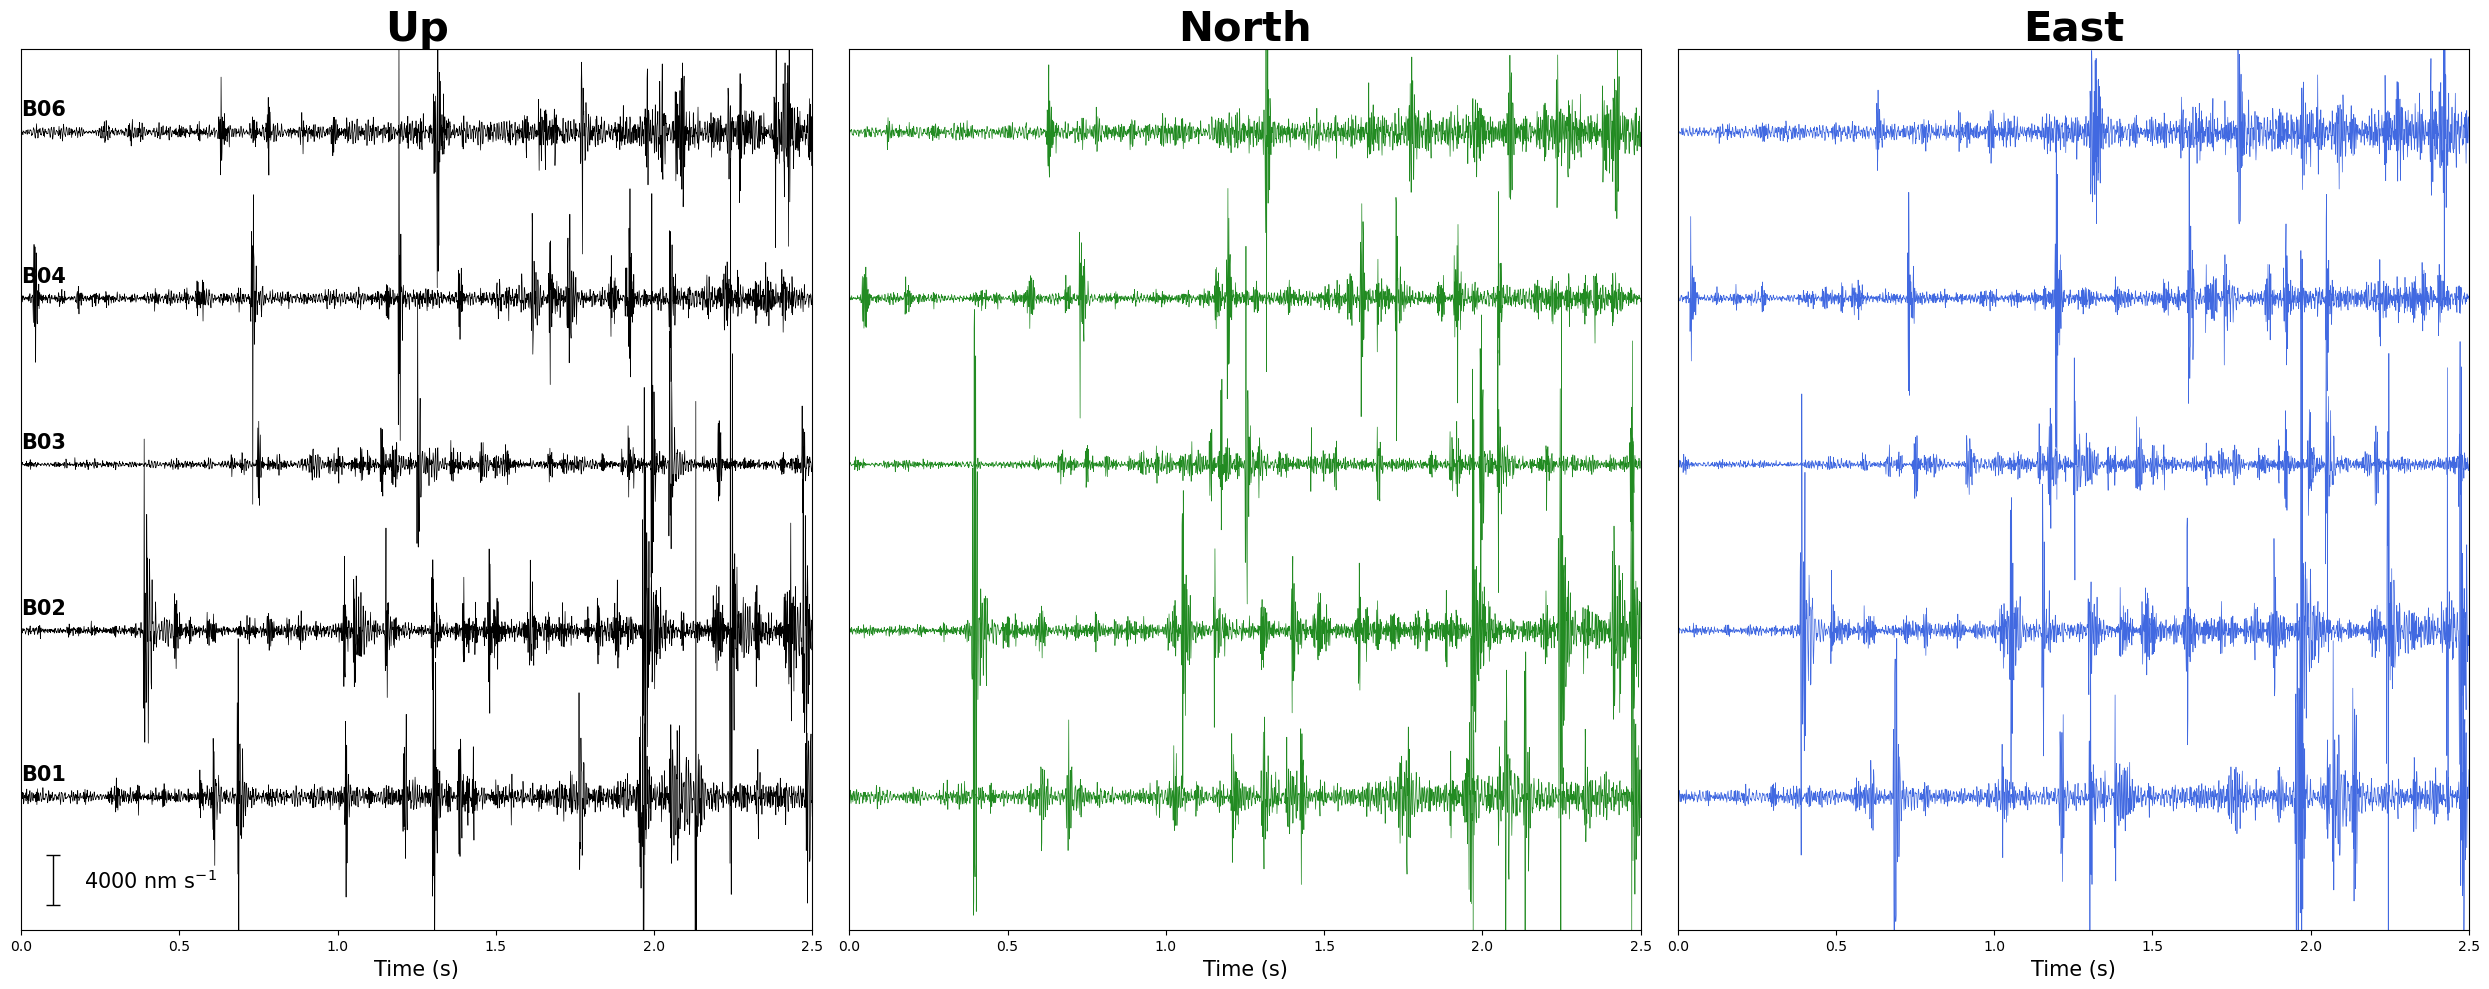

In [84]:
fig, axes = subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(25, 2*numst))

### Loop over the stations
for i, station in enumerate(stadf["name"]):

    #### Exract and plot the waveforms
    try:
        trace_z = stream.select(station=station, channel="*Z")[0]
        trace_1 = stream.select(station=station, channel="*1")[0]
        trace_2 = stream.select(station=station, channel="*2")[0]

        data_z = trace_z.data * scale + i
        data_1 = trace_1.data * scale + i
        data_2 = trace_2.data * scale + i
    except:
        print(f"Could not plot {station}")
        continue
    
    #### Convert the time axis to Pandas Timestamps
    timeax = trace_z.times()


    axes[0].plot(timeax, data_z, color="black", linewidth=0.5)
    axes[1].plot(timeax, data_1, color="forestgreen", linewidth=0.5)
    axes[2].plot(timeax, data_2, color="royalblue", linewidth=0.5)

    axes[0].annotate(station, xy=(timeax[0], i+0.1), xycoords="data", fontsize=15, fontweight="bold")

    # #### Extract and plot the raw detections
    # if plot_detect:
    #     try:
    #         detdf = stalta_dict[station]
    #         detdf = detdf.loc[(detdf["trigger_time"] >= timeax[0]) & (detdf["trigger_time"] <= timeax[-1])]
    #     except:
    #         print(f"No detections for {station}")
    #         continue

    #     axes[0].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)
    #     axes[1].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)
    #     axes[2].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)

    # #### Extract and plot the associated detections
    # if plot_assoc:
    #     for event in events:
    #         try:
    #             trigger, detrigger = event.get_triggers_by_station(station)
    #         except:
    #             continue
            
    #         axes[0].scatter(trigger, i, color="red", zorder=11, s=size)
    #         axes[1].scatter(trigger, i, color="red", zorder=11, s=size)
    #         axes[2].scatter(trigger, i, color="red", zorder=11, s=size)

## Plot the scale bar
y_center = -0.5
time_bar = 0.1
unit = "nm s$^{-1}$"
axes[0].errorbar(time_bar, y_center, yerr=scalebar * scale/2, xerr=None, capsize=5, color='black', fmt='-', linewidth=1)
axes[0].text(time_bar + 0.1, y_center, f"{scalebar} {unit}", fontsize=15, va='center', ha='left')

## Set the x-axis limits
axes[0].set_xlim([timeax[0], timeax[-1]])
axes[1].set_xlim([timeax[0], timeax[-1]])
axes[2].set_xlim([timeax[0], timeax[-1]])

## Set the y-axis limits
axes[0].set_ylim([-0.8, numst-0.5])

# ## Format x-axis as date time
# axes[0].xaxis.set_major_tick_params(rotation=45)
# axes[1].xaxis.set_major_tick_params(rotation=45)
# axes[2].xaxis.set_major_tick_params(rotation=45)

# for label in axes[0].get_xticklabels():
#     label.set_fontsize(15)
#     label.set_verticalalignment('top')
#     label.set_horizontalalignment('right')
#     label.set_rotation(10)

# for label in axes[1].get_xticklabels():
#     label.set_fontsize(15)
#     label.set_verticalalignment('top')
#     label.set_horizontalalignment('right')
#     label.set_rotation(10)

# for label in axes[2].get_xticklabels():
#     label.set_fontsize(15)
#     label.set_verticalalignment('top')
#     label.set_horizontalalignment('right')
#     label.set_rotation(10)

# Set titles
axes[0].set_title("Up", fontsize=30, fontweight="bold")
axes[1].set_title("North", fontsize=30, fontweight="bold")
axes[2].set_title("East", fontsize=30, fontweight="bold")

# Set x labels
axes[0].set_xlabel("Time (s)", fontsize=15)
axes[1].set_xlabel("Time (s)", fontsize=15)
axes[2].set_xlabel("Time (s)", fontsize=15)


# Turn off the y-axis labels and ticks
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[2].set_yticks([])

axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.tight_layout()
fig.patch.set_alpha(0.0)

## Save the figure
filename = f"inner_station_sample_waveforms_{subarray.lower()}.png"

outpath = join(ROOTDIR, timewin, filename)
fig.savefig(outpath, dpi=300)
print(f"Saved to {outpath}")